In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

from collections import Counter

In [4]:
data = pd.read_csv('train_events.csv')
video = pd.read_csv( 'video_info_v2.csv')
targets = pd.read_csv( 'train_targets.csv')

# Удаление видео у которых мало просмотров

In [9]:
def dell_vid(data, number_of_views):
    ddd = data['rutube_video_id'].value_counts().index.tolist() 
    vc = data['rutube_video_id'].value_counts()
    ee = []
    for i in ddd:
        if vc[i] > number_of_views:
            ee.append(i)
    data = data[data['rutube_video_id'].isin(ee)]
    return data
data = dell_vid(data, 1000)
data

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid
2,2024-06-01 21:30:43+03:00,St.-Petersburg,desktop,browser,Windows,Chrome,5647,video_96775,10894333
5,2024-06-01 04:11:51+03:00,Rostov,smartphone,mobile app,Android,Rutube,60,video_61152,10013813
9,2024-06-01 16:09:52+03:00,St.-Petersburg,smartphone,mobile app,Android,Rutube,2266,video_241755,10090266
13,2024-06-01 22:42:42+03:00,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,377,video_155983,10055534
19,2024-06-01 23:39:57+03:00,Moscow,tablet,mobile app,Android,Rutube,3211,video_96775,10043828
...,...,...,...,...,...,...,...,...,...
1759591,2024-06-30 03:58:02+03:00,Arkhangelskaya,smartphone,mobile app,Android,Rutube,3209,video_433627,10079008
1759607,2024-06-30 15:58:04+03:00,Yamalo-Nenets,desktop,browser,Windows,Chrome,1661,video_86744,10015493
1759608,2024-06-30 22:36:20+03:00,Smolensk Oblast,desktop,browser,Windows,Chrome,1191,video_134349,10079904
1759612,2024-06-30 01:20:16+03:00,Moscow,smartphone,browser,Android,Firefox Mobile,382,video_316157,10417567


# Функция препроцессинга, возвращает dataframe со всему нужными данными

In [187]:
def dataset_for_hand_maid(data_path, video_path, target_path):
    
    data = pd.read_csv('train_events.csv')
    video = pd.read_csv( 'video_info_v2.csv')
    targets = pd.read_csv( 'train_targets.csv')

    #Удаление видео у которых мало просмотров
    data = dell_vid(data, 1000)

    #Создание временного ряда видео
    unique_values = data['rutube_video_id'].unique()
    mapping = {value: i for i, value in enumerate(unique_values)}
    df = data[['viewer_uid','rutube_video_id']]
    df['rutube_video_id'] = df['rutube_video_id'].map(mapping)

    #добавляем таргеты
    df_grouped = df.groupby('viewer_uid')['rutube_video_id'].apply(list).reset_index(name='videos')
    merg = pd.merge(targets[['viewer_uid','age_class','sex']],df_grouped, on='viewer_uid')

    
    merg.loc[merg['sex']=='male','sex'] = 1
    merg.loc[merg['sex']=='female','sex'] = 0

    #достаем инфу о категориях которые смотрит пользователь
    """
    usr_vid = data.merge(video, on='rutube_video_id')
    usr_cat = usr_vid[['viewer_uid','category']]
    usr_cat = pd.get_dummies(usr_cat, columns=['category'])
    usr_cat = usr_cat.groupby('viewer_uid').sum()
    all_cat = list(usr_cat.columns)
    usr_cat = usr_cat.reset_index()
    merg = pd.merge(merg,usr_cat, on='viewer_uid')

    #достаем инфу о устройстве пользователя
    usr_dev = data[['viewer_uid','ua_device_type']]
    usr_dev = pd.get_dummies(usr_dev, columns=['ua_device_type'])
    usr_dev = usr_dev.groupby('viewer_uid').sum()
    usr_dev = usr_dev.reset_index()
    merg = pd.merge(merg,usr_dev, on='viewer_uid')

    #достаем инфу о опеационке пользователя
    usr_os = data[['viewer_uid','ua_os']]
    usr_os = pd.get_dummies(usr_os, columns=['ua_os'])
    usr_os = usr_os.groupby('viewer_uid').sum()
    usr_os = usr_os.reset_index()
    merg = pd.merge(merg,usr_os, on='viewer_uid')
"""

    return merg, unique_values #unique_values понадобятся потом для тестового набора данных 
merg , unique_values= dataset_for_hand_maid('train_events.csv', 'video_info_v2.csv', 'train_targets.csv')
merg

C:\Users\oklad\AppData\Local\Temp\ipykernel_23268\1876021120.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rutube_video_id'] = df['rutube_video_id'].map(mapping)


,viewer_uid,age_class,sex,videos
0,10087154,1,1,"[117, 117]"
1,10190464,2,1,[66]
2,10736308,1,0,[115]
3,10182639,3,1,[110]
4,10186548,3,1,[74]
...,...,...,...,...
96927,10041231,2,0,[125]
96928,10237402,3,0,"[46, 75, 104, 130]"
96929,10796936,2,1,"[125, 14, 14, 76, 98, 128]"
96930,10684284,1,1,"[70, 86]"


# для тестового набора данныз

In [152]:
def dataset_for_hand_maid_test(data_path, video_path, unique_values):
    
    data = pd.read_csv('train_events.csv')
    video = pd.read_csv( 'video_info_v2.csv')


    #Удаление видео у которых мало просмотров
    data = dell_vid(data, 1000)

    #Создание временного ряда виде
    mapping = {value: i for i, value in enumerate(unique_values)}
    df = data[['viewer_uid','rutube_video_id']]
    df['rutube_video_id'] = df['rutube_video_id'].map(mapping)
    merg = df.groupby('viewer_uid')['rutube_video_id'].apply(list).reset_index(name='videos')


    
    #достаем инфу о категориях которые смотрит пользователь
    """
    usr_vid = data.merge(video, on='rutube_video_id')
    usr_cat = usr_vid[['viewer_uid','category']]
    usr_cat = pd.get_dummies(usr_cat, columns=['category'])
    usr_cat = usr_cat.groupby('viewer_uid').sum()
    all_cat = list(usr_cat.columns)
    usr_cat = usr_cat.reset_index()
    merg = pd.merge(merg,usr_cat, on='viewer_uid')

    #достаем инфу о устройстве пользователя
    usr_dev = data[['viewer_uid','ua_device_type']]
    usr_dev = pd.get_dummies(usr_dev, columns=['ua_device_type'])
    usr_dev = usr_dev.groupby('viewer_uid').sum()
    usr_dev = usr_dev.reset_index()
    merg = pd.merge(merg,usr_dev, on='viewer_uid')

    #достаем инфу о опеационке пользователя
    usr_os = data[['viewer_uid','ua_os']]
    usr_os = pd.get_dummies(usr_os, columns=['ua_os'])
    usr_os = usr_os.groupby('viewer_uid').sum()
    usr_os = usr_os.reset_index()
    merg = pd.merge(merg,usr_os, on='viewer_uid')
"""

    return merg #unique_values понадобятся потом для тестового набора данных 
    
merg = dataset_for_hand_maid_test('train_events.csv', 'video_info_v2.csv', unique_values)
merg

C:\Users\oklad\AppData\Local\Temp\ipykernel_23268\3993426495.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rutube_video_id'] = df['rutube_video_id'].map(mapping)


,viewer_uid,videos
0,10000001,"[5, 34, 15, 20, 0, 68, 96, 124]"
1,10000004,"[60, 100, 105, 110, 95, 118, 121, 133, 133, 136]"
2,10000011,[131]
3,10000016,[61]
4,10000020,"[56, 95, 100, 100]"
...,...,...
96927,11140249,[125]
96928,11140346,[12]
96929,11140485,"[28, 24, 23, 29]"
96930,11140684,[99]


# Если хочется обрезать пользователей по просмотрам

In [106]:
merg['len'] = merg['videos'].apply(lambda x: len(x))
merg = merg[merg['len']>10]

# Для Пола

In [167]:
def Sex_data(merg):
    Count_tokens = 64
    
    YS = merg['sex'].to_list()
    X = merg['videos'].to_list()
    
    for i in range(len(X)):
      a = [0 for i in range(Count_tokens)]
      for j in range(len(X[i])):
        if j == Count_tokens:
            break
        a[j] = X[i][j]
      X[i] = a

    from sklearn.model_selection import train_test_split

    labels_train = YS
    
    for i in range(len(labels_train)):
      a = [0 for i in range(2)]
      a[labels_train[i]]=1
      labels_train[i] = a
    
    for i in range(len(labels_train)):
      labels_train[i] = np.array(labels_train[i])
    labels_train = np.array(labels_train)
    
    
    for i in range(len(X)):
      X[i] = np.array(X[i])
    X = np.array(X).astype('int32')
    
    
    X = np.concatenate((X,np.array(merg[merg.columns[4:]])),axis=1).astype('int32')
    x_train, x_test, y_train, y_test = train_test_split(X, labels_train, shuffle=True, random_state=42)


    print(x_train.shape, y_train.shape)
    print(x_test.shape, y_test.shape)
    return x_train, x_test, y_train, y_test
    
    
x_train, x_test, y_train, y_test  = Sex_data(merg)

(72699, 64) (72699, 2)
(24233, 64) (24233, 2)


## Для тестовых данных

In [178]:
def Sex_data_test(merg):
    Count_tokens = 64
    
    X = merg['videos'].to_list()
    
    for i in range(len(X)):
      a = [0 for i in range(Count_tokens)]
      for j in range(len(X[i])):
        if j == Count_tokens:
            break
        a[j] = X[i][j]
      X[i] = a

   
    for i in range(len(X)):
      X[i] = np.array(X[i])
    X = np.array(X)
    
    
    X = np.concatenate((X,np.array(merg[merg.columns[4:]])),axis=1).astype('int32')


    
    return X
    
    
X  = Sex_data_test(merg)
X

array([[117, 117,   0, ...,   0,   0,   0],
       [ 66,   0,   0, ...,   0,   0,   0],
       [115,   0,   0, ...,   0,   0,   0],
       ...,
       [125,  14,  14, ...,   0,   0,   0],
       [ 70,  86,   0, ...,   0,   0,   0],
       [ 32,  34,   0, ...,   0,   0,   0]])

In [162]:
CLASS_LIST = [0,1]
CLASS_COUNT = len(CLASS_LIST)
VOCAB_SIZE = len(unique_values)
WIN_SIZE = 64

In [170]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


class LC_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, win_size, class_count):
        super(LC_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.spatial_dropout = nn.Dropout(0.2)
        self.conv1d = nn.Conv1d(in_channels=embedding_dim, out_channels=20, kernel_size=5)
        self.max_pooling = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.2)
        self.batch_norm = nn.BatchNorm1d(20)
        self.lstm = nn.LSTM(20, 4, batch_first=True)
        self.dropout_1 = nn.Dropout(0.2)
        self.batch_norm_1 = nn.BatchNorm1d(4)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(120+len(merg.columns[4:]), class_count)
        self.softmax = nn.Softmax()

    def forward(self, x):
        fi = x[:,64:]
        x = x[:,:64]
        
        x = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
       
        x = self.spatial_dropout(x)
       
        x = torch.transpose(x,2,1)
       
        x = self.conv1d(x)  # [batch_size, seq_len - filter_size + 1, output_channels]
      
        x = self.max_pooling(x)  # [batch_size, (seq_len - filter_size + 1) // 2, output_channels]
       
        x = self.dropout(x)
        
        
        x = self.batch_norm(x)
       
        x = torch.transpose(x,2,1)

        x, _ = self.lstm(x)  # hn - скрытый вектор, cn - ячейка, x - выход LSTM
       
        x = self.dropout_1(x)
        x = self.batch_norm_1(x.permute(0, 2, 1)).permute(0, 2, 1)

        x = self.flatten(x)  # [batch_size, output_channels * (seq_len - filter_size + 1) // 2]
        
        x = torch.cat((x, fi), -1)
        
        x = self.dense(x)  # [batch_size, class_count]
        x = self.softmax(x)  # [batch_size, class_count]
        return x

# Создание модели
model_LC_3 = LC_Model(vocab_size=VOCAB_SIZE, embedding_dim=10, win_size=64, class_count=2)  # Замените на ваши значения

# Обучение
optimizer = optim.Adam(model_LC_3.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [171]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Создаем  датасеты
train_dataset = TensorDataset(torch.tensor(x_train).to(device), torch.tensor(y_train.astype('float32')).to(device))
test_dataset = TensorDataset(torch.tensor(x_test).to(device), torch.tensor(y_test.astype('float32')).to(device))

# Создаем  dataloader
train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Создаем  модель
model_LC_3 = LC_Model(vocab_size=VOCAB_SIZE, embedding_dim=10, win_size=WIN_SIZE, class_count=CLASS_COUNT).to(device)

# Определяем  оптимизатор  и  функцию  потери
optimizer = optim.Adam(model_LC_3.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Обучение
epochs = 10
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    # Обучение  на  обучающей  выборке
    model_LC_3.train()  # Переводим  модель  в  режим  обучения
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model_LC_3(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
        predicted = (output.data > 0.5).float() # Получаем  индекс  класса  с  максимальной  вероятностью
        total += target.size(0)
        correct += (predicted == target).sum().item()/2

    train_loss /= len(train_loader.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    # Проверка  на  тестовой  выборке
    model_LC_3.eval()  # Переводим  модель  в  режим  оценки
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():  # Отключаем  вычисление  градиентов
        for data, target in test_loader:
            output = model_LC_3(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)
            predicted = (output.data > 0.5).float()
            total += target.size(0)
            correct += (predicted == target).sum().item()/2

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch+1}/{epochs}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/10, Train Loss: 0.5752, Train Accuracy: 0.7187
Epoch 1/10, Test Loss: 0.5392, Test Accuracy: 0.7677
Epoch 2/10, Train Loss: 0.5440, Train Accuracy: 0.7606
Epoch 2/10, Test Loss: 0.5322, Test Accuracy: 0.7741
Epoch 3/10, Train Loss: 0.5385, Train Accuracy: 0.7655
Epoch 3/10, Test Loss: 0.5304, Test Accuracy: 0.7739
Epoch 4/10, Train Loss: 0.5354, Train Accuracy: 0.7682
Epoch 4/10, Test Loss: 0.5294, Test Accuracy: 0.7730
Epoch 5/10, Train Loss: 0.5333, Train Accuracy: 0.7697
Epoch 5/10, Test Loss: 0.5273, Test Accuracy: 0.7742
Epoch 6/10, Train Loss: 0.5313, Train Accuracy: 0.7709
Epoch 6/10, Test Loss: 0.5269, Test Accuracy: 0.7751
Epoch 7/10, Train Loss: 0.5308, Train Accuracy: 0.7707
Epoch 7/10, Test Loss: 0.5265, Test Accuracy: 0.7744
Epoch 8/10, Train Loss: 0.5296, Train Accuracy: 0.7712
Epoch 8/10, Test Loss: 0.5260, Test Accuracy: 0.7744
Epoch 9/10, Train Loss: 0.5290, Train Accuracy: 0.7719
Epoch 9/10, Test Loss: 0.5257, Test Accuracy: 0.7746
Epoch 10/10, Train Loss: 0.5

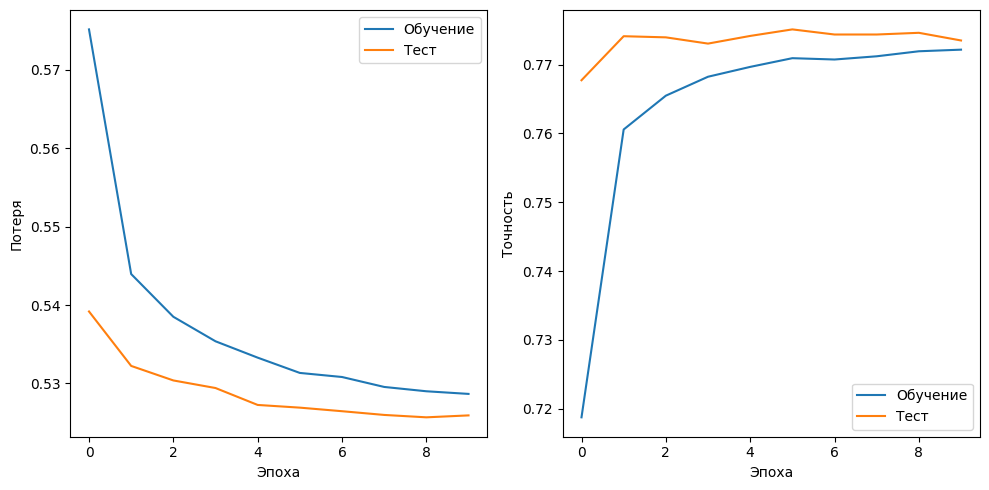

In [172]:
# Построение  графика
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Обучение')
plt.plot(test_losses, label='Тест')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Обучение')
plt.plot(test_accuracies, label='Тест')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

plt.tight_layout()
plt.show()

In [173]:
f = True

with torch.no_grad():  # Отключаем  вычисление  градиентов
        for data, target in test_loader:
            output = model_LC_3(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)
            predicted = (output.data > 0.5).float()

            if f:
                all_pred = (np.array(predicted.cpu()))
                all_labels = (np.array(target.cpu()))
                f = False
            else:
                all_pred = np.concatenate((all_pred, (np.array(predicted.cpu()))))
                all_labels = np.concatenate((all_labels, np.array(target.cpu())))

In [174]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_pred))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83     14925
           1       0.77      0.59      0.67      9308

   micro avg       0.77      0.77      0.77     24233
   macro avg       0.77      0.74      0.75     24233
weighted avg       0.77      0.77      0.77     24233
 samples avg       0.77      0.77      0.77     24233



## для тестовых данных

In [184]:
test_dataset = TensorDataset(torch.tensor(X).to(device))
test_loader = DataLoader(test_dataset, batch_size=32)

f = True

with torch.no_grad():  # Отключаем  вычисление  градиентов
        for data in test_loader:
            output = model_LC_3(data[0])
            
            predicted = (output.data > 0.5).float()

            if f:
                all_pred = (np.array(predicted.cpu()))
             
                f = False
            else:
                all_pred = np.concatenate((all_pred, (np.array(predicted.cpu()))))

all_pred               

C:\Users\oklad\anaconda3\envs\tf-gpu\lib\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

# Для Возраста

In [188]:
def Age_data(merg):
    Count_tokens = 64
    
    YE = merg['age_class'].to_list()
    X = merg['videos'].to_list()
    
    for i in range(len(X)):
      a = [0 for i in range(Count_tokens)]
      for j in range(len(X[i])):
        if j == Count_tokens:
            break
        a[j] = X[i][j]
      X[i] = a

    from sklearn.model_selection import train_test_split

    labels_train = YE
    
    for i in range(len(labels_train)):
      a = [0 for i in range(4)]
      a[labels_train[i]]=1
      labels_train[i] = a
    
    for i in range(len(labels_train)):
      labels_train[i] = np.array(labels_train[i])
    labels_train = np.array(labels_train)
    
    
    for i in range(len(X)):
      X[i] = np.array(X[i])
    X = np.array(X)
    
    
    X = np.concatenate((X,np.array(merg[merg.columns[4:]])),axis=1).astype('int32')
    x_train, x_test, y_train, y_test = train_test_split(X, labels_train, shuffle=True, random_state=42)


    print(x_train.shape, y_train.shape)
    print(x_test.shape, y_test.shape)
    return x_train, x_test, y_train, y_test
    
    
x_train, x_test, y_train, y_test  = Age_data(merg)

(72699, 64) (72699, 4)
(24233, 64) (24233, 4)


## для теста

In [ ]:
def Age_data_test(merg):
    Count_tokens = 64
    
    X = merg['videos'].to_list()
    
    for i in range(len(X)):
      a = [0 for i in range(Count_tokens)]
      for j in range(len(X[i])):
        if j == Count_tokens:
            break
        a[j] = X[i][j]
      X[i] = a

   
    for i in range(len(X)):
      X[i] = np.array(X[i])
    X = np.array(X)
    
    
    X = np.concatenate((X,np.array(merg[merg.columns[4:]])),axis=1).astype('int32')


    
    return X
    
    
X  = Age_data_test(merg)
X

In [189]:
CLASS_LIST = [0,1,2,3]
CLASS_COUNT = len(CLASS_LIST)
VOCAB_SIZE = len(unique_values)
WIN_SIZE = 64

In [190]:
class LC_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, win_size, class_count):
        super(LC_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.spatial_dropout = nn.Dropout(0.2)
        self.conv1d = nn.Conv1d(in_channels=embedding_dim, out_channels=20, kernel_size=5)
        self.max_pooling = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.2)
        self.batch_norm = nn.BatchNorm1d(20)
        self.lstm = nn.LSTM(20, 4, batch_first=True)
        self.dropout_1 = nn.Dropout(0.2)
        self.batch_norm_1 = nn.BatchNorm1d(4)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(120+len(merg.columns[4:]), class_count)
        self.softmax = nn.Softmax()

    def forward(self, x):
        fi = x[:,64:]
        x = x[:,:64]
        
        x = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
       
        x = self.spatial_dropout(x)
       
        x = torch.transpose(x,2,1)
       
        x = self.conv1d(x)  # [batch_size, seq_len - filter_size + 1, output_channels]
      
        x = self.max_pooling(x)  # [batch_size, (seq_len - filter_size + 1) // 2, output_channels]
       
        x = self.dropout(x)
        
        
        x = self.batch_norm(x)
       
        x = torch.transpose(x,2,1)

        x, _ = self.lstm(x)  # hn - скрытый вектор, cn - ячейка, x - выход LSTM
       
        x = self.dropout_1(x)
        x = self.batch_norm_1(x.permute(0, 2, 1)).permute(0, 2, 1)

        x = self.flatten(x)  # [batch_size, output_channels * (seq_len - filter_size + 1) // 2]
        
        x = torch.cat((x, fi), -1)
        
        x = self.dense(x)  # [batch_size, class_count]
        x = self.softmax(x)  # [batch_size, class_count]
        return x

# Создание модели
model_LC_3 = LC_Model(vocab_size=VOCAB_SIZE, embedding_dim=10, win_size=64, class_count=4)  # Замените на ваши значения

# Обучение
optimizer = optim.Adam(model_LC_3.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [191]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Создаем  датасеты
train_dataset = TensorDataset(torch.tensor(x_train).to(device), torch.tensor(y_train.astype('float32')).to(device))
test_dataset = TensorDataset(torch.tensor(x_test).to(device), torch.tensor(y_test.astype('float32')).to(device))

# Создаем  dataloader
train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Создаем  модель
model_LC_3 = LC_Model(vocab_size=VOCAB_SIZE, embedding_dim=10, win_size=WIN_SIZE, class_count=CLASS_COUNT).to(device)

# Определяем  оптимизатор  и  функцию  потери
optimizer = optim.Adam(model_LC_3.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Обучение
epochs = 10
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    # Обучение  на  обучающей  выборке
    model_LC_3.train()  # Переводим  модель  в  режим  обучения
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model_LC_3(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
        mask = np.arange(np.array(output.data.cpu()).shape[1]) == np.argmax(np.array(output.data.cpu()), axis=1)[:, None]
        predicted = np.where(mask, 1, 0)# Получаем  индекс  класса  с  максимальной  вероятностью
        total += target.size(0)
        correct += np.sum(np.all(predicted == np.array(target.cpu()), axis=1))

    train_loss /= len(train_loader.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    # Проверка  на  тестовой  выборке
    model_LC_3.eval()  # Переводим  модель  в  режим  оценки
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():  # Отключаем  вычисление  градиентов
        for data, target in test_loader:
            output = model_LC_3(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)
            mask = np.arange(np.array(output.data.cpu()).shape[1]) == np.argmax(np.array(output.data.cpu()), axis=1)[:, None]
            predicted = np.where(mask, 1, 0)# Получаем  индекс  класса  с  максимальной  вероятностью
            total += target.size(0)
            correct += np.sum(np.all(predicted == np.array(target.cpu()), axis=1))

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch+1}/{epochs}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

C:\Users\oklad\anaconda3\envs\tf-gpu\lib\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/10, Train Loss: 1.2935, Train Accuracy: 0.3915
Epoch 1/10, Test Loss: 1.2759, Test Accuracy: 0.4236
Epoch 2/10, Train Loss: 1.2760, Train Accuracy: 0.4186
Epoch 2/10, Test Loss: 1.2639, Test Accuracy: 0.4309
Epoch 3/10, Train Loss: 1.2676, Train Accuracy: 0.4283
Epoch 3/10, Test Loss: 1.2589, Test Accuracy: 0.4370
Epoch 4/10, Train Loss: 1.2635, Train Accuracy: 0.4334
Epoch 4/10, Test Loss: 1.2569, Test Accuracy: 0.4431
Epoch 5/10, Train Loss: 1.2606, Train Accuracy: 0.4377
Epoch 5/10, Test Loss: 1.2551, Test Accuracy: 0.4465
Epoch 6/10, Train Loss: 1.2569, Train Accuracy: 0.4460
Epoch 6/10, Test Loss: 1.2538, Test Accuracy: 0.4485
Epoch 7/10, Train Loss: 1.2557, Train Accuracy: 0.4471
Epoch 7/10, Test Loss: 1.2539, Test Accuracy: 0.4497
Epoch 8/10, Train Loss: 1.2543, Train Accuracy: 0.4481
Epoch 8/10, Test Loss: 1.2530, Test Accuracy: 0.4511
Epoch 9/10, Train Loss: 1.2534, Train Accuracy: 0.4515
Epoch 9/10, Test Loss: 1.2529, Test Accuracy: 0.4533
Epoch 10/10, Train Loss: 1.2

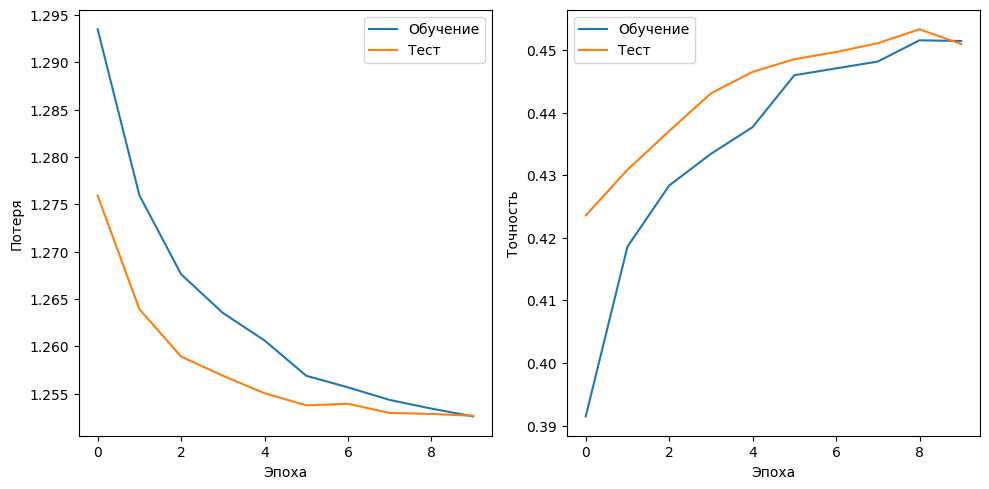

In [192]:
# Построение  графика
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Обучение')
plt.plot(test_losses, label='Тест')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Обучение')
plt.plot(test_accuracies, label='Тест')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

plt.tight_layout()
plt.show()

In [193]:
f = True

with torch.no_grad():  # Отключаем  вычисление  градиентов
        for data, target in test_loader:
            output = model_LC_3(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)
            mask = np.arange(np.array(output.data.cpu()).shape[1]) == np.argmax(np.array(output.data.cpu()), axis=1)[:, None]
            predicted = np.where(mask, 1, 0)

            if f:
                all_pred = (np.array(predicted))
                all_labels = (np.array(target.cpu()))
                f = False
            else:
                all_pred = np.concatenate((all_pred, (np.array(predicted))))
                all_labels = np.concatenate((all_labels, np.array(target.cpu())))

In [194]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       939
           1       0.45      0.77      0.57      9131
           2       0.44      0.25      0.32      9447
           3       0.48      0.33      0.39      4716

   micro avg       0.45      0.45      0.45     24233
   macro avg       0.34      0.34      0.32     24233
weighted avg       0.44      0.45      0.41     24233
 samples avg       0.45      0.45      0.45     24233



C:\Users\oklad\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## для теста

In [196]:
test_dataset = TensorDataset(torch.tensor(X).to(device))
test_loader = DataLoader(test_dataset, batch_size=32)


f = True

with torch.no_grad():  # Отключаем  вычисление  градиентов
        for data in test_loader:
            output = model_LC_3(data[0])
            
            mask = np.arange(np.array(output.data.cpu()).shape[1]) == np.argmax(np.array(output.data.cpu()), axis=1)[:, None]
            predicted = np.where(mask, 1, 0)

            if f:
                all_pred = (np.array(predicted))
                
                f = False
            else:
                all_pred = np.concatenate((all_pred, (np.array(predicted))))
all_pred                

array([[0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       ...,
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0]])